In [20]:
from mpi4py import MPI
import gmsh

# Initialize gmsh
gmsh.initialize()
gmsh.model.add("rect_with_partial_interface")
ref = 1
if MPI.COMM_WORLD.rank == 0:
    # --------------------------
    # Parameters
    # --------------------------
    Lx, Ly = 10.0, 10.0
    y_start, y_end = 8.0, 4.0
    x_start, x_end = 2.0, 8.0
    # lc = 10.0/ 10.0 / (2**ref)          # mesh size
    lc = 8.0
    order = 1         # element order

    # --------------------------
    # 1. Define rectangular domain Ω
    # --------------------------
    p1 = gmsh.model.occ.addPoint(0, 0, 0, lc)
    p2 = gmsh.model.occ.addPoint(Lx, 0, 0, lc)
    p3 = gmsh.model.occ.addPoint(Lx, Ly, 0, lc)
    p4 = gmsh.model.occ.addPoint(0, Ly, 0, lc)
    l1 = gmsh.model.occ.addLine(p1, p2)
    l2 = gmsh.model.occ.addLine(p2, p3)
    l3 = gmsh.model.occ.addLine(p3, p4)
    l4 = gmsh.model.occ.addLine(p4, p1)
    loop = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
    surf = gmsh.model.occ.addPlaneSurface([loop])

    # --------------------------
    # 2. Add an internal partial horizontal line Γ
    # --------------------------
    p5 = gmsh.model.occ.addPoint(x_start, y_start, 0, lc)
    p6 = gmsh.model.occ.addPoint(x_end, y_end, 0, lc)
    l5 = gmsh.model.occ.addLine(p5, p6)

    # --------------------------
    # 3. Fragment the surface with the internal line (split mesh)
    # --------------------------
    gmsh.model.occ.fragment([(2, surf)], [(1, l5)])
    gmsh.model.occ.synchronize()

    # --------------------------
    # 4. Define physical groups
    # --------------------------
    # Surface (bulk Ω)
    gmsh.model.addPhysicalGroup(2, [surf], 1)
    gmsh.model.setPhysicalName(2, 1, "Omega")

    # Identify the internal line (Γ)
    all_lines = gmsh.model.getEntities(dim=1)
    # print(all_lines)
    gamma_tag = all_lines[0][1]  # the last 1D entity created
    gmsh.model.addPhysicalGroup(1, [gamma_tag], 2)
    gmsh.model.setPhysicalName(1, 2, "Gamma")

    # Optionally, tag boundary (outer edges)
    outer_edges = [l1, l2, l3, l4]
    gmsh.model.addPhysicalGroup(1, outer_edges, 3)
    gmsh.model.setPhysicalName(1, 3, "Boundary")

    # --------------------------
    # 5. Generate and save mesh
    # --------------------------
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.setOrder(order)
    gmsh.write("diagonal.msh")

gmsh.finalize()
from mpi4py import MPI
from dolfinx import mesh, fem
import ufl
import numpy as np

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
# Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
from dolfinx.io import gmsh as gmshio
# Read the same .msh
msh, cell_markers, facet_markers = gmshio.read_from_msh("diagonal.msh", MPI.COMM_WORLD, 0, gdim=2)[0:3]


# Extract the 1D interface mesh from the 2D mesh (like igridView)
# interface = mesh.create_submesh(domain, domain.topology.dim - 1, np.arange(domain.topology.index_map(domain.topology.dim - 1).size_local, dtype=np.int32))[0]

tdim = msh.topology.dim  # 2
fdim = tdim - 1             # 1

# Find all facets tagged as Gamma (tag=2)
omega = msh
gamma_entities = facet_markers.find(2)

# Create a submesh for Γ (same as gamma in the JSDokken example)
gamma, gamma_to_omega = mesh.create_submesh(omega, fdim, gamma_entities)[0:2]

# Define interface tag ID (as defined in Gmsh)
Gamma_tag = 2  # <-- replace with your actual tag ID for the interface Γ

# ---------------------------------------------------------------------
# 2. Function spaces
# ---------------------------------------------------------------------
order = 2
V_m = fem.functionspace(omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
dp_m, dp_f, dl = ufl.TrialFunctions(W)
p_m = fem.Function(V_m, name="p_m")
p_f = fem.Function(V_f, name="p_f")
lmbd = fem.Function(V_f, name="lmbd")

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(msh)
f_m = fem.Constant(msh, 0.0)
f_f = fem.Constant(msh, 0.0)

k_m = fem.Constant(omega, 1.0)
k_f = fem.Constant(gamma, 100.0)

dx = ufl.Measure("dx", domain=omega)
ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
dx_f = ufl.Measure("dx", domain=gamma)

# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
# Coupling term with interface (approximate; corresponds to avg/trace in DUNE)
# In the Dokken example, coupling to Γ is done via ds(Gamma_tag)
# Here we use the interface integral directly on ds(Gamma_tag)
# (You can later replace lmbd with an actual trace variable or interface function)
a_m1 = -lmbd * phi * ds
a_m = a_m0 + a_m1
L_m = f_m * phi * dx

# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds
# a_f0 = ufl.inner(ufl.grad(p_f), ufl.grad(psi)) * dx_f
# a_f1 = lmbd * psi * dx_f
# a_f = a_f0 + a_f1
# L_f = f_f * psi * dx_f

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
# Dokken’s example handles this through interface coupling on ds(Gamma_tag)
a_l0 = p_m * mu * ds
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(msh, 0.0) * mu * ds

# a_l0 = p_m * mu * ds
# a_l1 = -p_f * mu * dx_f
# a_l = a_l0 + a_l1
# L_l = fem.Constant(msh, 0.0) * mu * dx_f

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

# ---------------------------------------------------------------------
# Print symbolic forms (optional sanity check)
# ---------------------------------------------------------------------
print("a_m =", a_m)
print("a_gamma =", a_gamma)

F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

jac = ufl.derivative(F, p_m, dp_m) + ufl.derivative(F, p_f, dp_f) + ufl.derivative(F, lmbd, dl)
J = ufl.extract_blocks(jac)

# Compute bounding box to locate sides
coords = omega.geometry.x
x = coords[:, 0]
y = coords[:, 1]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 10.0
p_m_bc.x.array[top_dofs]  = 10.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

bcs = [bc_pm]

from dolfinx.fem import petsc
entity_maps = [gamma_to_omega]



# entity_maps = [gamma_to_omega]
# entity_maps = [gamma_to_omega]
nlp = petsc.NonlinearProblem(
    residual,
    u=[p_m, p_f, lmbd],
    J=J,
    bcs=bcs,
    entity_maps=entity_maps,
    petsc_options={
        "snes_monitor": None,
        "snes_max_it": 500,
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "mat_mumps_icntl_14": 120,
        "ksp_error_if_not_converged": True,
        "snes_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_",
)
max_iterations = 25
normed_diff = 0
tol = 1e-5

nlp.solve()
iterations = nlp.solver.getIterationNumber()
print(f"Converged in {iterations} Newton iterations")

Info    : Meshing 1D...                                                                                                  
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.000683232s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000535373s, CPU 0s)
Info    : 14 nodes 33 elements
Info    : Writing 'diagonal.msh'...
Info    : Done writing 'diagonal.msh'
Info    : Reading 'diagonal.msh'...
Info    : 12 entities
Info    : 14 nodes
Info    : 19 elements
Info    : Done reading 'diagonal.msh'
a_m = { ({ A | A_{i_{24}} = c_42 * (grad(p_m))[i_{24}] }) : (grad(v_0^0)) } * dx(<Mesh #16>[everywhere], {})
  +  { v_0^0 * -1 * lmbd } * ds(<Mesh #16>[2], {})
a_gamma = { ({ A | A_{i_{25}} = c_43 * (grad(p_f))[i_{25}] }) : (grad(v_0^1)) } * ds(<Mesh

  0 SNES Function norm 9.098188965276e+01
  1 SNES Function norm 3.968759147917e-13
Converged in 1 Newton iterations


In [21]:
from scipy.interpolate import LinearNDInterpolator
import pyvista as pv
from dolfinx import plot
from scipy.spatial import cKDTree

# 1) Load MRST data (Pa) with header x,y,pressure
data = np.loadtxt("pressure_field_G.csv", delimiter=",", skiprows=1)
x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# Optional: sanity-check domain if needed (MRST is [0,10]x[0,10])
# assert x_mrst.min() >= 0 and x_mrst.max() <= 10 and y_mrst.min() >= 0 and y_mrst.max() <= 10

# 2) Interpolant from scattered MRST cell centroids to arbitrary (x,y)
interp = LinearNDInterpolator(np.c_[x_mrst, y_mrst], p_mrst, fill_value=np.nan)
# ---------- MRST -> UniformGrid (cell-centered) ----------
xs = np.unique(x_mrst)
ys = np.unique(y_mrst)
nx, ny = len(xs), len(ys)

# Map scattered centroids to a 2D array (row=y, col=x)
ix = np.searchsorted(xs, x_mrst)
iy = np.searchsorted(ys, y_mrst)
p_mrst_2d = np.full((ny, nx), np.nan, dtype=float)
p_mrst_2d[iy, ix] = p_mrst

dx = xs[1] - xs[0]
dy = ys[1] - ys[0]



/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


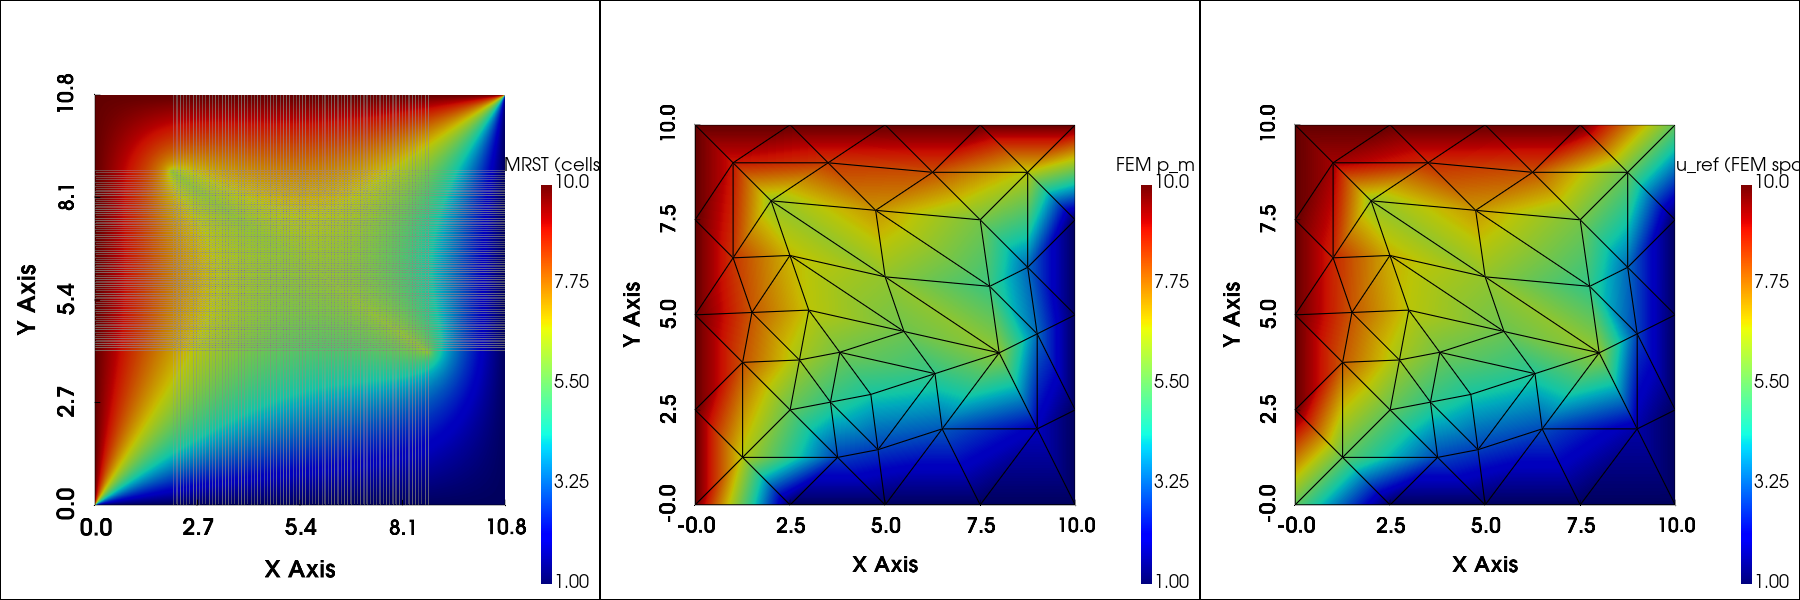

In [22]:
V = p_m.function_space
xdofs = V.tabulate_dof_coordinates()            # shape: (n_local_dofs, gdim)
vals = np.array([interp(x, y) for x, y in xdofs[:, :2]])

# Fallback for points slightly outside MRST convex hull: nearest neighbor
if np.any(np.isnan(vals)):
    nn = np.isnan(vals)
    tree = cKDTree(np.c_[x_mrst, y_mrst])
    _, idx = tree.query(xdofs[nn, :2])
    vals[nn] = p_mrst[idx]

u_ref = fem.Function(V)
u_ref.x.array[:] = vals

ug = pv.ImageData()
ug.dimensions = (nx + 1, ny + 1, 1)
ug.spacing = (dx, dy, 1.0)
ug.origin = (xs.min() - 0.5 * dx, ys.min() - 0.5 * dy, 0.0)
ug.cell_data["p_mrst"] = p_mrst_2d.T.ravel(order="F")

# ---------- Convert FEM fields to PyVista ----------
# 2D background (p_m)
topo2, ctype2, geom2 = plot.vtk_mesh(p_m.function_space)
grid_2d = pv.UnstructuredGrid(topo2, ctype2, geom2)
grid_2d.point_data["p_m"] = p_m.x.array.real

# 1D fracture (p_f)
topo1, ctype1, geom1 = plot.vtk_mesh(p_f.function_space)
grid_1d = pv.UnstructuredGrid(topo1, ctype1, geom1)
grid_1d.point_data["p_f"] = p_f.x.array.real

# u_ref on same 2D mesh as p_m
grid_ref = pv.UnstructuredGrid(topo2, ctype2, geom2.copy())
grid_ref.point_data["u_ref"] = u_ref.x.array.real

# ---------- Shared color limits ----------
mrst_min, mrst_max = float(np.nanmin(p_mrst_2d)), float(np.nanmax(p_mrst_2d))
fem_min = min(grid_2d.point_data["p_m"].min(),
              grid_1d.point_data["p_f"].min(),
              grid_ref.point_data["u_ref"].min())
fem_max = max(grid_2d.point_data["p_m"].max(),
              grid_1d.point_data["p_f"].max(),
              grid_ref.point_data["u_ref"].max())
vmin, vmax = min(mrst_min, fem_min), max(mrst_max, fem_max)

# ---------- Plot (1 x 3) ----------
plotter = pv.Plotter(shape=(1, 3), window_size=(1800, 600))

# Panel 1: MRST (cells)
plotter.subplot(0, 0)
plotter.add_mesh(
    ug, scalars="p_mrst", cmap="jet", show_edges=False, lighting=True,
    clim=[vmin, vmax],
    scalar_bar_args={"title": "MRST (cells)", "vertical": True, "width": 0.05, "height": 0.7}
)
plotter.show_bounds(); plotter.view_xy()

# Panel 2: FEM p_m (nodes) + p_f (line)
plotter.subplot(0, 1)
plotter.add_mesh(
    grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
    clim=[vmin, vmax],
    scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
)
# plotter.add_mesh(
#     grid_1d, scalars="p_f", cmap="jet", render_lines_as_tubes=True,
#     line_width=5, show_edges=False, clim=[vmin, vmax]
# )
plotter.show_bounds(); plotter.view_xy()

# Panel 3: u_ref (nodes)
plotter.subplot(0, 2)
plotter.add_mesh(
    grid_ref, scalars="u_ref", cmap="jet", show_edges=True, lighting=True,
    clim=[vmin, vmax],
    scalar_bar_args={"title": "u_ref (FEM space)", "vertical": True, "width": 0.05, "height": 0.7}
)
plotter.show_bounds(); plotter.view_xy()

plotter.link_views()
plotter.show()